# ACLO Notebook
Goal: load raw check-ins → build daily dataset → quick sanity checks


In [53]:
#Install packages for the project
!pip install pandas numpy seaborn matplotlib scikit-learn scipy networkx 
!pip -q install pandas pyarrow holidays

Import the required modules

In [54]:
# Import the required building blocks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing
from scipy import stats
import re
import holidays

# Correlation Matrix


In [55]:
df = pd.read_csv('data/Check-in times/Check-in-times_sheet_2017-2021 kaikki checkin timet yhes.csv')
df.head()


,Card nr,Affiliation,Gender,Subscription visit,Check-in date
0,168236,Medewerker RUG,M,Fitness Card 2016-2017,8/1/2017 12:49
1,132339,RUG,M,Fitness Card 2016-2017,8/1/2017 12:53
2,141170,RUG,M,Fitness Card 2016-2017,8/1/2017 12:53
3,141170,RUG,M,Fitness Card 2016-2017,8/1/2017 12:54
4,186817,RUG,M,Fitness Card 2016-2017,8/1/2017 13:00


In [56]:
df.dtypes

Card nr                int64
Affiliation           object
Gender                object
Subscription visit    object
 Check-in date        object
dtype: object

In [57]:
# Use your actual local path
FILE_PATH = r"data/Check-in times/Check-in-times_sheet_2017-2021 kaikki checkin timet yhes.csv"

# How many membership/product columns to keep (top-K by total volume); others collapse to "other"
TOP_K_MEMBERSHIPS = 15

# Holiday calendar country
COUNTRY_HOLIDAYS  = "NL"  # Netherlands



In [58]:
# 1) Read
raw = pd.read_csv(FILE_PATH, low_memory=False)

# 2) Clean header spaces, then rename to canonical names
raw.columns = [c.strip() for c in raw.columns]
raw = raw.rename(columns={
    "Card nr": "card_id",
    "Affiliation": "affiliation",          # note: original had a trailing space; we just stripped it above
    "Gender": "gender",
    "Subscription visit": "subscription",
    "Check-in date": "checkin_dt",         # original had a leading space; stripped above
})

# Quick audit so we know what we’re working with:
print("Columns after rename:", list(raw.columns))

# 3) Parse datetimes & per-day date
raw["checkin_dt"] = pd.to_datetime(raw["checkin_dt"], errors="coerce")
raw["date"] = raw["checkin_dt"].dt.floor("D")

# 4) Normalize text
raw["affil_cf"] = raw["affiliation"].astype("string").str.strip().str.casefold()
raw["gender_cf"] = raw["gender"].astype("string").str.strip().str.lower()
raw["subscription_cf"] = raw["subscription"].astype("string").str.strip()

# 5) Affiliation buckets: rug / hanze / other
def normalize_affil(s: str) -> str:
    s = (s or "").lower()
    if "hanze" in s:
        return "hanze"
    if "rug" in s or "rijksuniversiteit" in s or "university of groningen" in s:
        return "rug"
    return "other"

raw["affil_clean"] = raw["affil_cf"].fillna("").map(normalize_affil)

# 6) Staff within RUG only (e.g., “Medewerker RUG”)
raw["is_staff_rug"] = raw["affil_cf"].str.contains("medewerker", na=False) & raw["affil_cf"].str.contains("rug", na=False)

# 7) Ensure card_id is usable for distinct counts
raw["card_id"] = pd.to_numeric(raw["card_id"], errors="coerce").astype("Int64")

raw.head()


Columns after rename: ['card_id', 'affiliation', 'gender', 'subscription', 'checkin_dt']


,card_id,affiliation,gender,subscription,checkin_dt,date,affil_cf,gender_cf,subscription_cf,affil_clean,is_staff_rug
0,168236,Medewerker RUG,M,Fitness Card 2016-2017,2017-08-01 12:49:00,2017-08-01,medewerker rug,m,Fitness Card 2016-2017,rug,True
1,132339,RUG,M,Fitness Card 2016-2017,2017-08-01 12:53:00,2017-08-01,rug,m,Fitness Card 2016-2017,rug,False
2,141170,RUG,M,Fitness Card 2016-2017,2017-08-01 12:53:00,2017-08-01,rug,m,Fitness Card 2016-2017,rug,False
3,141170,RUG,M,Fitness Card 2016-2017,2017-08-01 12:54:00,2017-08-01,rug,m,Fitness Card 2016-2017,rug,False
4,186817,RUG,M,Fitness Card 2016-2017,2017-08-01 13:00:00,2017-08-01,rug,m,Fitness Card 2016-2017,rug,False


In [59]:
start = pd.to_datetime(raw["date"].min())
end   = pd.to_datetime(raw["date"].max())
calendar = pd.DataFrame({"date": pd.date_range(start, end, freq="D")})

calendar["year"]            = calendar["date"].dt.year
calendar["month"]           = calendar["date"].dt.month
calendar["iso_week"]        = calendar["date"].dt.isocalendar().week.astype(int)
calendar["day_of_week"]     = calendar["date"].dt.day_name()
calendar["day_of_week_num"] = calendar["date"].dt.weekday       # 0=Mon ... 6=Sun
calendar["hour"]            = 0
calendar["is_weekend"]      = (calendar["day_of_week_num"] >= 5).astype(int)

# Seasons: 0=Winter,1=Spring,2=Summer,3=Fall
season_num = ((calendar["month"] % 12) // 3)
season_map = {0: "Winter", 1: "Spring", 2: "Summer", 3: "Fall"}
calendar["season_num"] = season_num
calendar["season"]     = calendar["season_num"].map(season_map)

# Holidays (Netherlands)
years = range(calendar["date"].dt.year.min(), calendar["date"].dt.year.max() + 1)
hol = holidays.Netherlands(years=years) if COUNTRY_HOLIDAYS.upper() == "NL" else holidays.CountryHoliday(COUNTRY_HOLIDAYS, years=years)
calendar["is_holiday"] = calendar["date"].isin(hol).astype(int)

# Exam periods — fill if you have them
exam_periods = [
     ("2018-10-29", "2018-11-02"),
     ("2019-01-21", "2019-03-29"),
     ("2019-06-24", "2019-11-01"),
     ("2020-01-20", "2020-03-27"),
     ("2020-06-22", "2021-03-26"),
     ("2021-06-21", "2022-03-25"),
     ("2022-06-20", "2022-06-24"),

]
calendar["is_exam_period"] = 0
for s, e in exam_periods:
    mask = (calendar["date"] >= pd.to_datetime(s)) & (calendar["date"] <= pd.to_datetime(e))
    calendar.loc[mask, "is_exam_period"] = 1

calendar.head()


C:\Users\korho\AppData\Local\Temp\ipykernel_16608\2825354001.py:22: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  calendar["is_holiday"] = calendar["date"].isin(hol).astype(int)


,date,year,month,iso_week,day_of_week,day_of_week_num,hour,is_weekend,season_num,season,is_holiday,is_exam_period
0,2017-08-01,2017,8,31,Tuesday,1,0,0,2,Summer,0,0
1,2017-08-02,2017,8,31,Wednesday,2,0,0,2,Summer,0,0
2,2017-08-03,2017,8,31,Thursday,3,0,0,2,Summer,0,0
3,2017-08-04,2017,8,31,Friday,4,0,0,2,Summer,0,0
4,2017-08-05,2017,8,31,Saturday,5,0,1,2,Summer,0,0


In [60]:
# Helper to make safe column suffixes
def slug(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"\W+", "_", s)
    return s.strip("_")

# Totals (raw check-ins)
total_checkins = raw.groupby("date").size().rename("total_checkins").sort_index()

# Unique visitors per day (distinct cards)
unique_visitors = raw.groupby("date")["card_id"].nunique(dropna=True).rename("unique_visitors").sort_index()

# Unique by gender -> columns like visitors_m, visitors_f, visitors_other...
g_daily = (
    raw.groupby(["date", raw["gender_cf"]])["card_id"]
       .nunique(dropna=True)
       .unstack(fill_value=0)
       .sort_index()
)
g_daily.columns = [f"visitors_{slug(c)}" for c in g_daily.columns]

# --- Your four categories (unique visitors per day) ---
def nunique_daily(mask, name):
    # (If you want raw check-in counts instead, replace .nunique(...) with .size())
    return (
        raw.loc[mask]
           .groupby("date")["card_id"]
           .nunique(dropna=True)
           .rename(name)
           .sort_index()
    )

vis_affil_rug    = nunique_daily(raw["affil_clean"] == "rug",   "visitors_affil_rug")
vis_affil_hanze  = nunique_daily(raw["affil_clean"] == "hanze", "visitors_affil_hanze")
vis_affil_other  = nunique_daily(raw["affil_clean"] == "other", "visitors_affil_other")
vis_staff_rug    = nunique_daily(raw["is_staff_rug"],           "visitors_staff_rug")

# --- Membership/product top-K per day (from 'subscription') ---
if TOP_K_MEMBERSHIPS and TOP_K_MEMBERSHIPS > 0:
    mem_daily = (
        raw.groupby(["date", "subscription_cf"])
           .size().rename("count")
           .reset_index()
    )
    top_memberships = (
        mem_daily.groupby("subscription_cf")["count"]
                 .sum()
                 .sort_values(ascending=False)
                 .head(TOP_K_MEMBERSHIPS)
                 .index
    )
    mem_daily["mem_bucket"] = np.where(
        mem_daily["subscription_cf"].isin(top_memberships),
        mem_daily["subscription_cf"],
        "other"
    )
    mem_pivot = (
        mem_daily.groupby(["date", "mem_bucket"])["count"]
                 .sum()
                 .unstack(fill_value=0)
                 .sort_index()
    )
    mem_share = (mem_pivot.T / mem_pivot.sum(axis=1)).T.fillna(0)
    mem_share.columns = [f"{slug(c)}_share" for c in mem_share.columns]
else:
    # Empty frames that still align on index
    dates = unique_visitors.index
    mem_pivot = pd.DataFrame(index=dates)
    mem_share = pd.DataFrame(index=dates)


In [61]:
daily = (
    calendar
    .merge(total_checkins, on="date", how="left")
    .merge(unique_visitors, on="date", how="left")
    .merge(g_daily, left_on="date", right_index=True, how="left")
    .merge(mem_pivot, left_on="date", right_index=True, how="left")
    .merge(mem_share, left_on="date", right_index=True, how="left")
    .merge(vis_affil_rug,   on="date", how="left")
    .merge(vis_affil_hanze, on="date", how="left")
    .merge(vis_affil_other, on="date", how="left")
    .merge(vis_staff_rug,   on="date", how="left")
)

# Fill numeric NaNs with 0
num_cols = daily.select_dtypes(include=["number"]).columns
daily[num_cols] = daily[num_cols].fillna(0)

# Cast count-like columns to int (shares remain float)
count_like = set(mem_pivot.columns) | {
    "total_checkins", "unique_visitors",
    "visitors_affil_rug", "visitors_affil_hanze", "visitors_affil_other",
    "visitors_staff_rug",
} | {c for c in daily.columns if c.startswith("visitors_")}
for c in sorted(count_like & set(daily.columns)):
    daily[c] = daily[c].astype("int64")

# Nice column order
first_cols = [
    "date", "year", "month", "iso_week", "day_of_week", "day_of_week_num",
    "hour", "is_weekend", "season_num", "season", "is_holiday", "is_exam_period",
    "total_checkins", "unique_visitors",
    "visitors_affil_rug", "visitors_affil_hanze", "visitors_affil_other",
    "visitors_staff_rug",
]
rest_cols = [c for c in daily.columns if c not in first_cols]
daily = daily[first_cols + rest_cols]

daily.head()


,date,year,month,iso_week,day_of_week,day_of_week_num,hour,is_weekend,season_num,season,...,fitness_card_2018_2019_share,fitness_card_2019_2020_share,fitness_card_2020_2021_share,fitness_card_2021_2022_share,fitness_free_card_2017_2018_share,fitness_midseason_card_2017_2018_share,fitness_free_card_2018_2019_share,fitness_free_card_2019_2020_share,spr_sportcard_incasso_share,other_share
0,2017-08-01,2017,8,31,Tuesday,1,0,0,2,Summer,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2017-08-02,2017,8,31,Wednesday,2,0,0,2,Summer,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2017-08-03,2017,8,31,Thursday,3,0,0,2,Summer,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2017-08-04,2017,8,31,Friday,4,0,0,2,Summer,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2017-08-05,2017,8,31,Saturday,5,0,1,2,Summer,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# If you kept mem_pivot, those are per-day check-in counts by product.
# They shouldn't exceed total_checkins.
if not mem_pivot.empty:
    mem_count_sum = daily[mem_pivot.columns].sum(axis=1)
    ok_mem = bool((mem_count_sum <= daily["total_checkins"]).all())
else:
    ok_mem = True

# Drop constant numeric columns before correlations
nunique = daily.select_dtypes(include=["number"]).nunique(dropna=False)
constant_cols = nunique[nunique <= 1].index.tolist()

ok_mem, constant_cols[:10]


(True, ['hour'])

In [63]:
# Save engineered daily table
daily.to_parquet("daily_aggregates.parquet", index=False)
daily.to_csv("daily_aggregates.csv", index=False)

# Correlation on numeric columns only (drop constants)
num = daily.select_dtypes(include=["number"]).drop(columns=constant_cols, errors="ignore")
corr = num.corr(method="pearson")  # or "spearman" for rank-based

corr.shape, corr.iloc[:5, :5]


((49, 49),
                      year     month  iso_week  day_of_week_num  is_weekend
 year             1.000000 -0.213102 -0.203965        -0.000816   -0.000168
 month           -0.213102  1.000000  0.974910         0.001132    0.003561
 iso_week        -0.203965  0.974910  1.000000        -0.002371   -0.001545
 day_of_week_num -0.000816  0.001132 -0.002371         1.000000    0.790657
 is_weekend      -0.000168  0.003561 -0.001545         0.790657    1.000000)

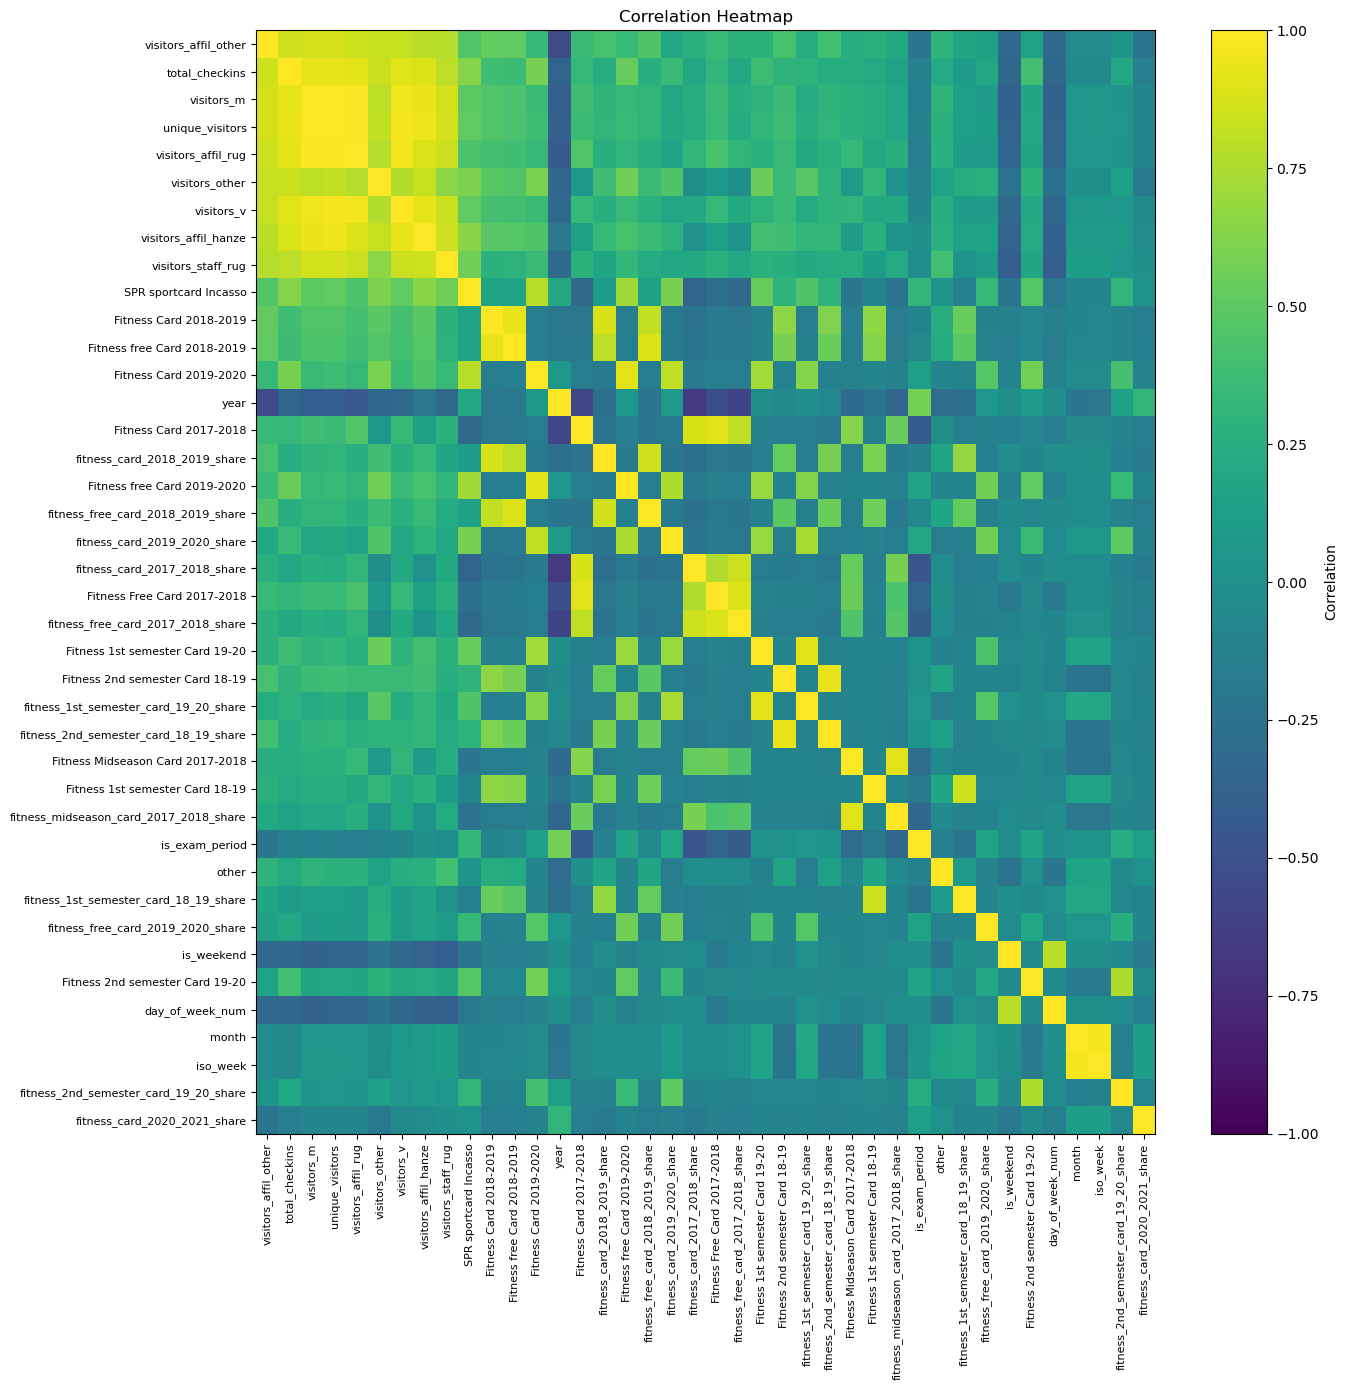

In [64]:
# Build/reuse correlation from your daily table, then plot as a heatmap.
import numpy as np
import matplotlib.pyplot as plt

# Recompute if 'corr' isn't defined yet
if 'corr' not in globals():
    num = daily.select_dtypes(include=["number"])
    nunique = num.nunique(dropna=False)
    num = num.loc[:, nunique > 1]  # drop constants
    corr = num.corr(method="pearson")

# Keep the heatmap readable for very wide tables
TOP_N = 40  # change if you want more/less variables
if corr.shape[0] > TOP_N:
    strength = corr.abs().sum().sort_values(ascending=False)
    keep = strength.index[:TOP_N]
    corr_plot = corr.loc[keep, keep]
else:
    corr_plot = corr

# Figure size scales with number of variables
fig_size = max(8, min(24, 0.35 * corr_plot.shape[0]))
plt.figure(figsize=(fig_size, fig_size))

im = plt.imshow(corr_plot, vmin=-1, vmax=1, interpolation="nearest", aspect="auto")
plt.colorbar(im, label="Correlation")

labels = [str(c)[:40] for c in corr_plot.columns]  # trim long names
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=8)
plt.yticks(np.arange(len(labels)), labels, fontsize=8)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


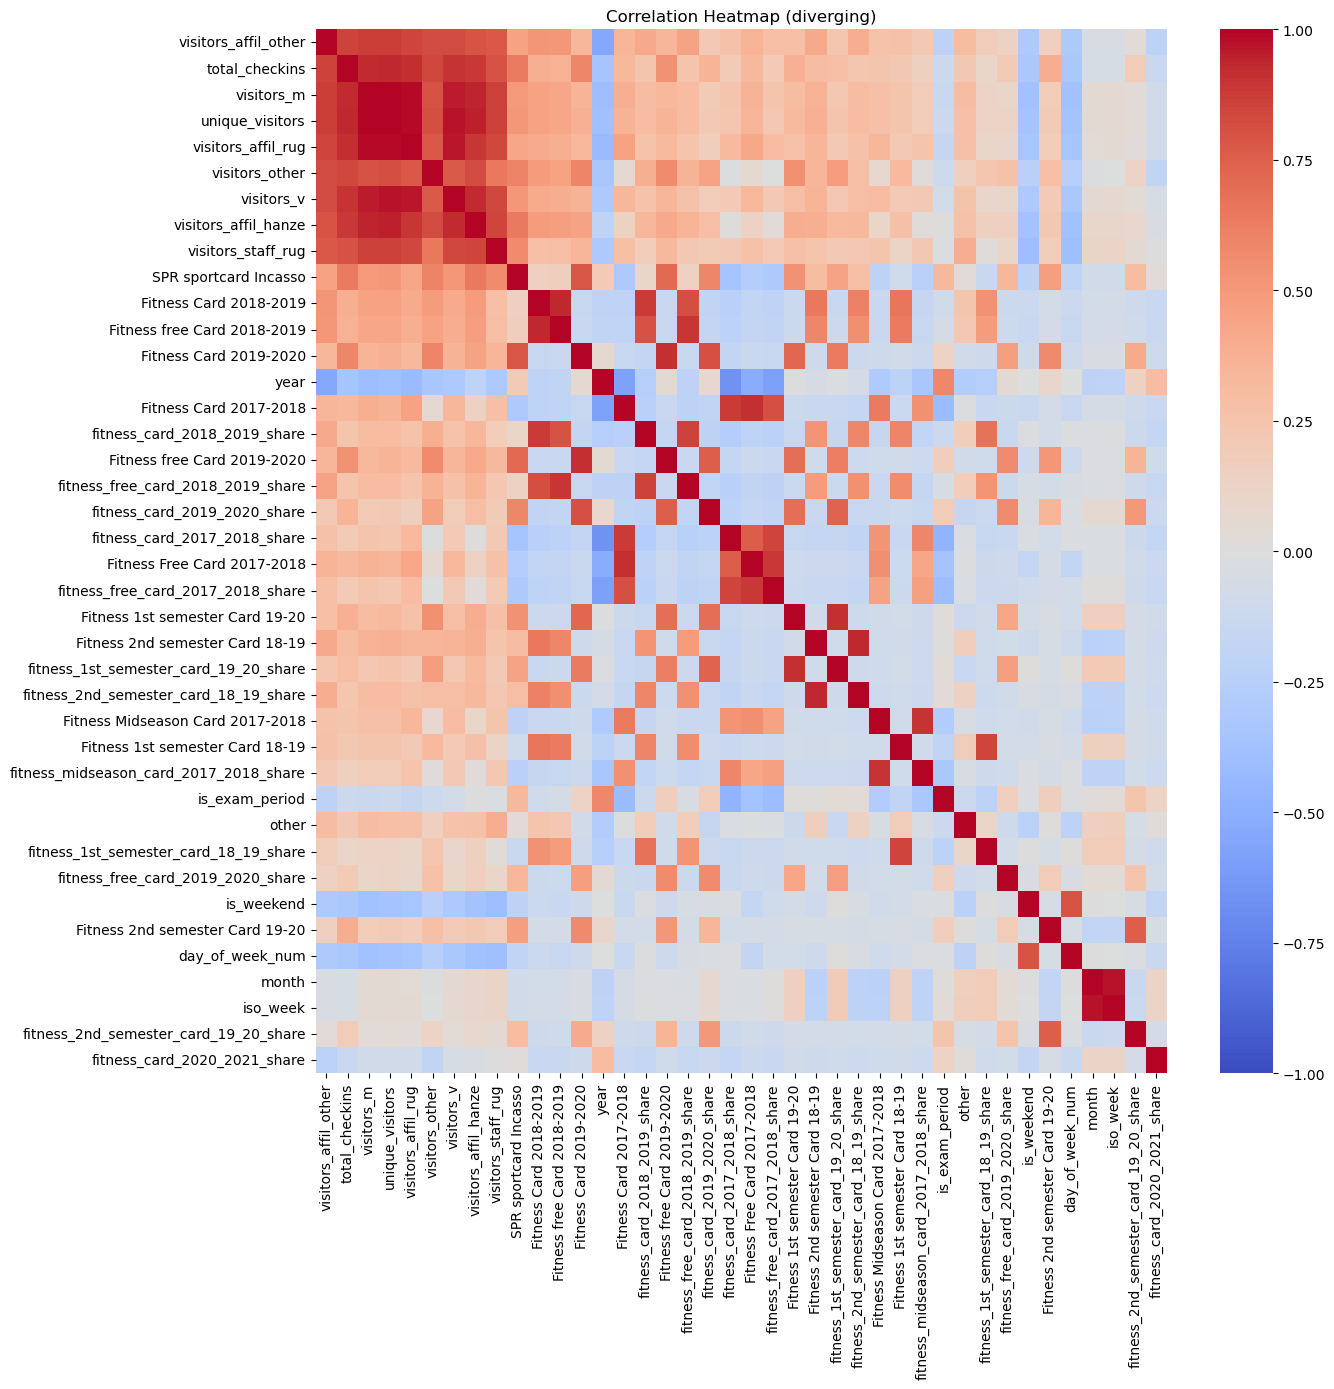

In [65]:
import seaborn as sns
plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(corr_plot, vmin=-1, vmax=1, center=0, cmap="coolwarm")
plt.title("Correlation Heatmap (diverging)")
plt.tight_layout()
plt.show()


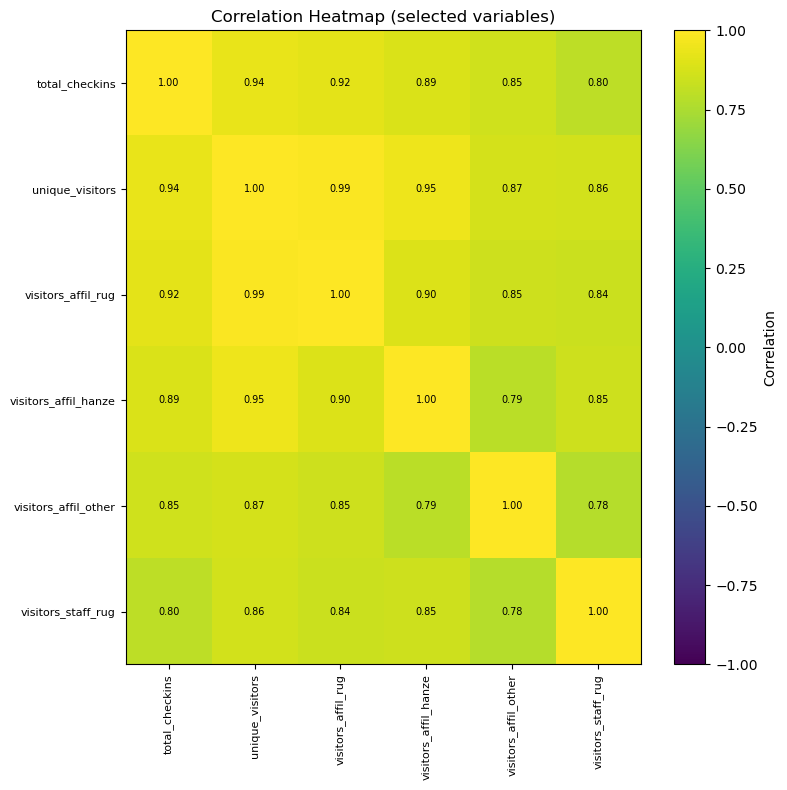

In [66]:
# Correlation heatmap with variable filtering + per-cell annotations (matplotlib only)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


# To remove variables, set STRATEGY = "manual" and edit MANUAL_KEEP.

# To keep/drop by name patterns, set STRATEGY = "patterns" and fill KEEP_PATTERNS / DROP_PATTERNS.

# To auto-reduce to the top-N most related to a target (e.g., total_checkins), set STRATEGY = "topN" and adjust TOPN_TARGET / TOPN_N.


# ===== 1) Choose how to select variables =====
STRATEGY = "manual"     # options: "manual", "patterns", "topN"

# -- A) Manual: list the columns you want to see
MANUAL_KEEP = [
    # Example: tweak this list to exactly what you want
    "total_checkins", "unique_visitors",
    "visitors_affil_rug", "visitors_affil_hanze", "visitors_affil_other",
    "visitors_staff_rug",
    # add/remove other columns from 'daily' here...
]

# -- B) Pattern-based keep/drop (regex). Leave empty list [] to skip.
KEEP_PATTERNS = [
    # r"^visitors_affil_",    # example: keep all affiliation visitor cols
    # r"_share$",             # example: keep all share columns
]
DROP_PATTERNS = [
    r"^year$", r"^month$", r"^iso_week$", r"^day_of_week$", r"^season$",  # non-numeric / labels
    # r"_share$",             # example: drop all share columns
]

# -- C) Top-N by absolute correlation with a target column
TOPN_TARGET = "total_checkins"
TOPN_N = 25


# ===== 2) Build the selected numeric dataframe =====
num_all = daily.select_dtypes(include=["number"]).copy()

# drop constant columns (no variance = useless for corr)
const_cols = num_all.columns[num_all.nunique(dropna=False) <= 1]
num_all = num_all.drop(columns=const_cols)

if STRATEGY == "manual":
    selected = [c for c in MANUAL_KEEP if c in num_all.columns]
elif STRATEGY == "patterns":
    def match_any(patterns, col):
        return any(re.search(p, col) for p in patterns)
    if KEEP_PATTERNS:
        selected = [c for c in num_all.columns if match_any(KEEP_PATTERNS, c)]
    else:
        selected = list(num_all.columns)
    if DROP_PATTERNS:
        selected = [c for c in selected if not match_any(DROP_PATTERNS, c)]
elif STRATEGY == "topN":
    cols = num_all.columns
    if TOPN_TARGET not in cols:
        raise ValueError(f"TOPN_TARGET '{TOPN_TARGET}' not found in numeric columns.")
    # rank by absolute correlation vs target
    scores = num_all.corrwith(num_all[TOPN_TARGET]).abs().sort_values(ascending=False)
    selected = scores.head(TOPN_N).index.tolist()
else:
    raise ValueError("STRATEGY must be one of: 'manual', 'patterns', 'topN'")

if len(selected) < 2:
    raise ValueError("Need at least 2 numeric columns selected to draw a correlation matrix.")

num_sel = num_all[selected]

# ===== 3) Compute correlation =====
corr = num_sel.corr(method="pearson")  # use "spearman" if you prefer ranks

# ===== 4) Plot heatmap with values in each cell =====
n = corr.shape[0]
fig_size = max(8, min(24, 0.4 * n))  # scale figure to number of vars
plt.figure(figsize=(fig_size, fig_size))

im = plt.imshow(corr, vmin=-1, vmax=1, interpolation="nearest", aspect="auto")
plt.colorbar(im, label="Correlation")

labels = [str(c) for c in corr.columns]
plt.xticks(np.arange(n), labels, rotation=90, fontsize=8)
plt.yticks(np.arange(n), labels, fontsize=8)
plt.title("Correlation Heatmap (selected variables)")

# annotate each cell with correlation value
for i in range(n):
    for j in range(n):
        val = corr.iat[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.show()


# Number of visits per time of day for all of the Check-in-time data



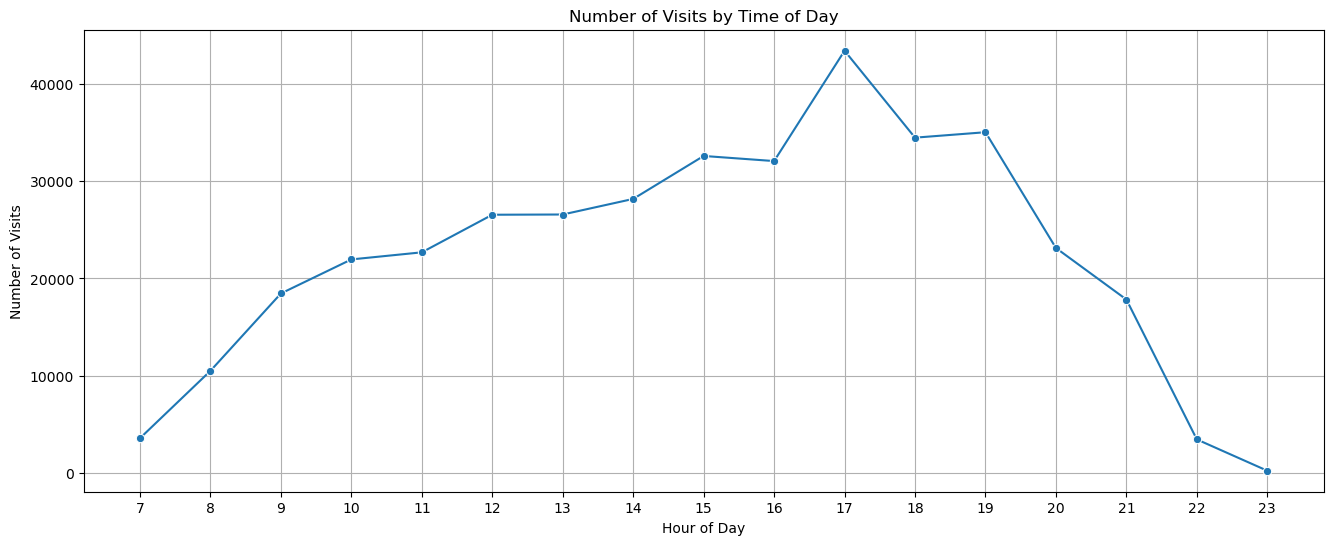

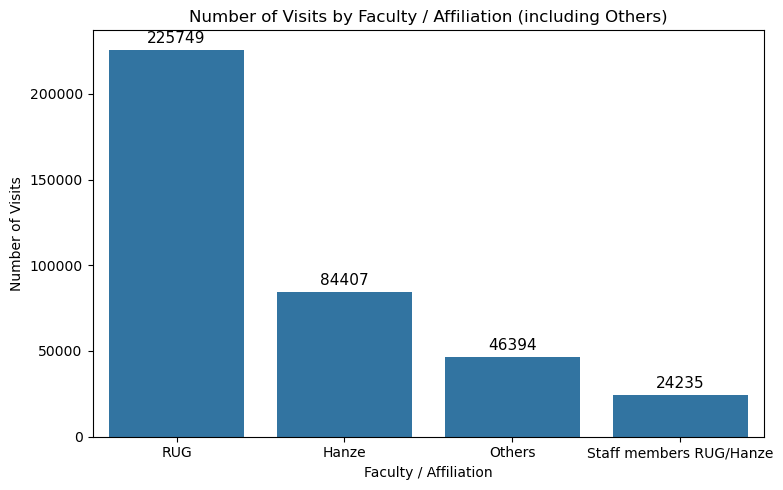

In [67]:

# Read the data from the specified file
df_visits = pd.read_csv('data/Check-in times/Check-in-times_sheet_2017-2021 kaikki checkin timet yhes.csv')

# Parse the check-in time column (assuming it's named like in your previous df)
# Find the column that contains 'date' in its name (case-insensitive)
time_col = [col for col in df_visits.columns if 'date' in col.lower()][0]

# Convert to datetime and extract hour
df_visits['hour'] = pd.to_datetime(df_visits[time_col], errors='coerce').dt.hour

# Count visits per hour
visits_per_hour = df_visits['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(16,6))
sns.lineplot(x=visits_per_hour.index, y=visits_per_hour.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Visits')
plt.title('Number of Visits by Time of Day')
plt.xticks(range(7, 24))
plt.grid(True)
plt.show()
# Only keep visits from RUG, Hanze, or Medewerkers RUG/Hanze
faculty_labels = ['RUG', 'Hanze', 'Staff member RUG/Hanze', 'Staff members RUG/Hanze']
faculty_col = 'Affiliation '  # already detected

# Normalize values for matching (strip and lower)
def normalize_faculty(val):
    if pd.isnull(val):
        return None
    val = str(val).strip().lower()
    if val == 'rug':
        return 'RUG'
    elif val == 'hanze':
        return 'Hanze'
    elif 'medewerker' in val and 'hanze' in val and 'rug' in val:
        return 'Staff members RUG/Hanze'
    return None
df_visits['faculty_group'] = df_visits[faculty_col].apply(normalize_faculty)

filtered = df_visits[df_visits['faculty_group'].isin(['RUG', 'Hanze', 'Staff members RUG/Hanze'])]

# Add "Others" group for visits not matching the three main faculty groups
filtered_faculties = ['RUG', 'Hanze', 'Staff members RUG/Hanze']
df_visits['faculty_group_full'] = df_visits['faculty_group'].where(
    df_visits['faculty_group'].isin(filtered_faculties), 'Others'
)

faculty_full_counts = df_visits['faculty_group_full'].value_counts().reindex(
    ['RUG', 'Hanze', 'Others', 'Staff members RUG/Hanze']
).fillna(0)

plt.figure(figsize=(8,5))
sns.barplot(x=faculty_full_counts.index, y=faculty_full_counts.values)
plt.xlabel('Faculty / Affiliation')
plt.ylabel('Number of Visits')
plt.title('Number of Visits by Faculty / Affiliation (including Others)')
for i, count in enumerate(faculty_full_counts.values):
    plt.text(i, count + max(faculty_full_counts.values)*0.01, int(count), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()



# Cardholder data

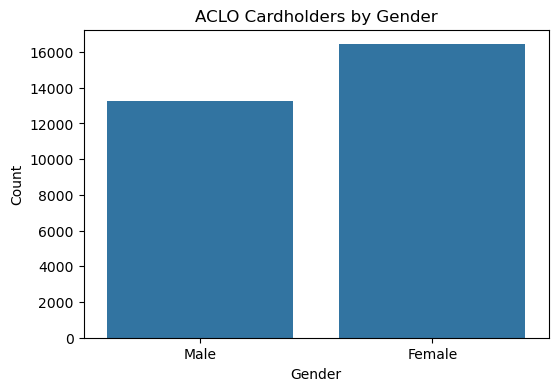

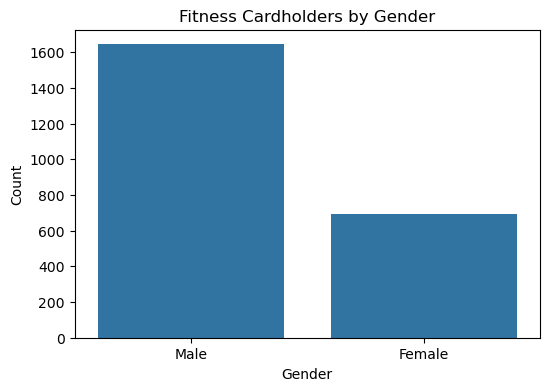

In [68]:
cardholders_full = pd.read_csv('data/Cardholders/Kaikki membership tyypit vuodet 2020-2022.csv')
cardholders_full.describe()

# Separate ACLO and Fitness cardholders
is_aclo = cardholders_full['Description'].str.contains('ACLO', case=False, na=False)
is_fitness = cardholders_full['Description'].str.contains('Fitness', case=False, na=False)

aclo_cardholders = cardholders_full[is_aclo]
fitness_cardholders = cardholders_full[is_fitness]

# Plot count by gender for ACLO cardholders
aclo_gender_counts = pd.Series({
    'Male': aclo_cardholders['Gender Male'].notnull().sum(),
    'Female': aclo_cardholders['Gender Female'].notnull().sum()
})
plt.figure(figsize=(6,4))
sns.barplot(x=aclo_gender_counts.index, y=aclo_gender_counts.values)
plt.title('ACLO Cardholders by Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

# Plot count by gender for Fitness cardholders
fitness_gender_counts = pd.Series({
    'Male': fitness_cardholders['Gender Male'].notnull().sum(),
    'Female': fitness_cardholders['Gender Female'].notnull().sum()
})
plt.figure(figsize=(6,4))
sns.barplot(x=fitness_gender_counts.index, y=fitness_gender_counts.values)
plt.title('Fitness Cardholders by Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()





# Check in times compared to academic caldenders



In [69]:
from matplotlib.lines import Line2D

# Add color for Exam Week if missing
if 'Exams' not in event_type_colors:
    event_type_colors['Exams'] = (0.5, 0.5, 0.5)  # gray or pick any color you like

plt.figure(figsize=(24, 14))
sns.lineplot(x=visits_per_day_2019.index, y=visits_per_day_2019.values, label='Daily Visits', color='blue')

calendar_events = calendar_df[calendar_df['date'] <= pd.to_datetime('2019-12-31')]
plt.subplots_adjust(left=0.07, right=0.99, top=0.97, bottom=0.13)
for _, row in calendar_events.iterrows():
    event_date = row['date']
    event_name = row['event_name']
    event_type = row['event_type']
    color = event_type_colors.get(event_type, 'orange')
    plt.axvline(x=event_date, color=color, alpha=0.5, linestyle='--')
    
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Visits', fontsize=14)
plt.title('Number of Visits per Day (up to 2019) with Academic Calendar Events', fontsize=18)
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)

# Custom legend for event types
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Daily Visits')]
for event_type, color in event_type_colors.items():
    legend_elements.append(Line2D([0], [0], color=color, lw=2, linestyle='--', label=event_type))
plt.legend(handles=legend_elements, fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

NameError: name 'event_type_colors' is not defined

# Effect of Covid-19 on the visitor numbers


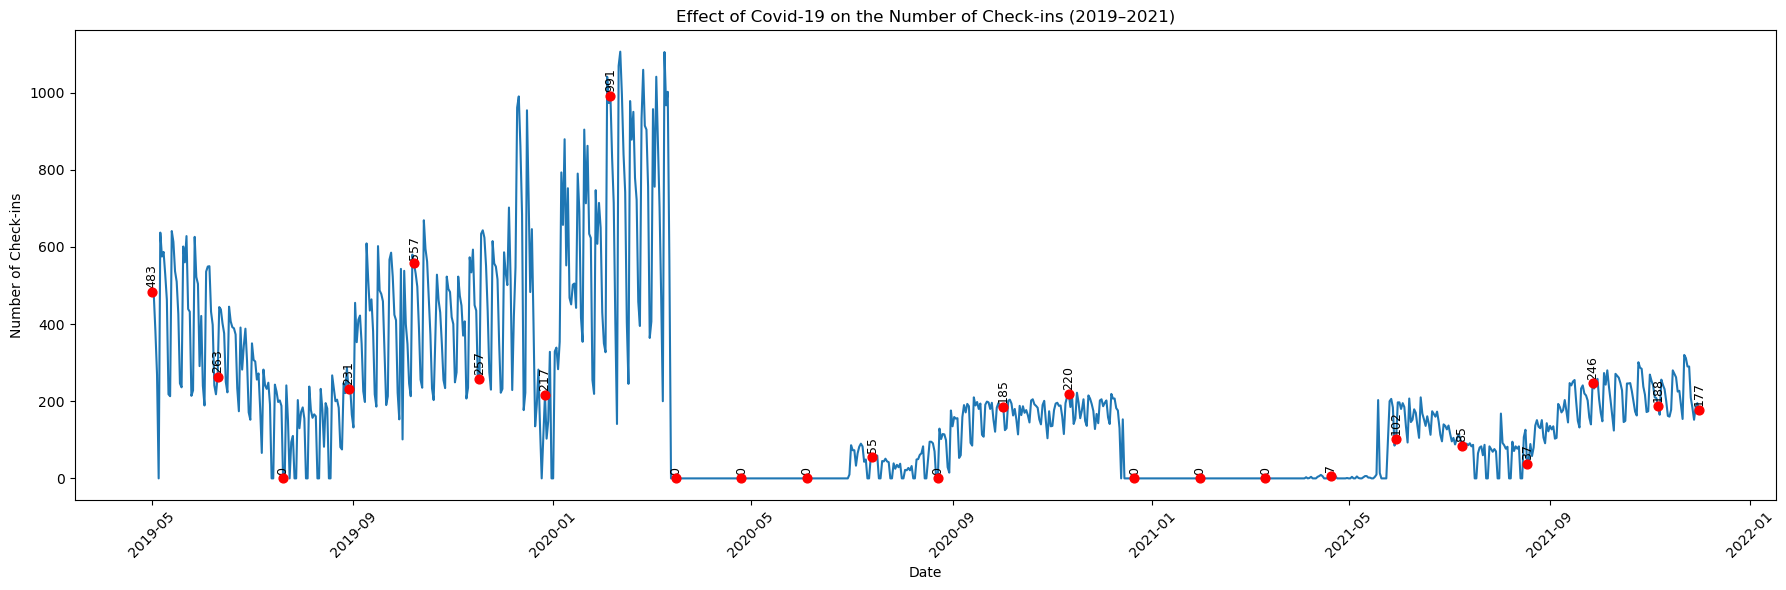

In [ ]:
# --- Build visits_per_day (adjust df_visits / time_col if yours differ) ---
# Guess the datetime column
time_col = [c for c in df_visits.columns if ('date' in c.lower() or 'time' in c.lower())][0]
df_visits[time_col] = pd.to_datetime(df_visits[time_col], errors='coerce')

# Count check-ins per day -> Series with DatetimeIndex
visits_per_day = (
    df_visits
      .dropna(subset=[time_col])
      .set_index(time_col)
      .resample('D')
      .size()
)

# --- Filter from 2019-05-01 (match types with Timestamp) ---
start = pd.Timestamp('2019-05-01')
visits_2019_on = visits_per_day.loc[visits_per_day.index >= start]

# --- Plot ---
plt.figure(figsize=(18, 6))
sns.lineplot(x=visits_2019_on.index, y=visits_2019_on.values)

# Add labels roughly every 40th point and the last one
for idx, (date, count) in enumerate(zip(visits_2019_on.index, visits_2019_on.values)):
    if idx % 40 == 0 or idx == len(visits_2019_on) - 1:
        plt.scatter(date, count, s=40, zorder=5, color='red')
        plt.text(date, count + 10, str(int(count)), ha='center', va='bottom',
                 fontsize=9, color='black', rotation=90)

plt.xlabel('Date')
plt.ylabel('Number of Check-ins')
plt.title('Effect of Covid-19 on the Number of Check-ins (2019–2021)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Regrission prediction

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Use KNeighborsRegressor with a smaller n_neighbors for an even closer fit

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X, y)
y_pred = knn.predict(X)
plt.figure(figsize=(18, 8))
mask = visits_per_day_lr['\nCheck-in date'] < pd.to_datetime('2020-01-01')
plt.plot(visits_per_day_lr.loc[mask, '\nCheck-in date'], y[mask], label='Actual Check-ins', color='blue')
plt.plot(visits_per_day_lr.loc[mask, '\nCheck-in date'], y_pred[mask], label='Predicted Check-ins (Linear Regression)', color='red', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Check-ins')
plt.title('Actual vs Predicted Check-ins')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'X' is not defined